Top 5 routes - FBPROPHET

|Depart - Destination Station|2018/2|scale & rounding|upper|2019/1|scale & rounding|upper|Remark
|----------------------------|------|----------------|-----|------|----------------|-----|------
|12 CU Terrace - 04 Engineering|69.9%|0.5 and 3|N|56.1%|0.1 and 9|N|logistics 0-5/0-6|
|04 Engineering - 12 CU Terrace|78.0%|0.8 and 3|N|57.0%|0.5 and 4|N|logistic no/0-3|
|12 CU Terrace - 03 Sala Prakeaw|81.6%|0.3 and 7|Y|80.0%|0.1 and 9|Y|logistics 0-3 both|
|02 Economics - 22 Siam Square Soi 8|80.5%|0.5 and 6|Y|72.6%|0.9 and 6|N|logistics 0-3, 0-4|
|04 Engineering - 21 Wittayakit Building|79.8%|0.6 and 4.5|Y|-|-|-|logistics 0-3|
|02 Economics - 21 Wittayakit Building|-|-|-|71.1%|0.9 and 8|N|logistics 0-4|
|02 Economics - 12 CU Terrace|-|-|-|68.1%|0.8 and 9|Y|logistics 0-4|

Top 5 routes - SARIMAX

|Depart - Destination Station|2018/2|SARIMAX|AIC|round|2019/1|SARIMAX|AIC|round|
|----------------------------|------|-------|---|-----|------|-------|---|-----|
|12 CU Terrace - 04 Engineering|69.1%|(1,0,2)x(2,0,2,15)|808.3|6|55.6%|(0,0,2)x(2,0,2,15)|837.0|6|
|04 Engineering - 12 CU Terrace|70.2%|(0,0,0)x(1,0,2,15)|562.0|5|65.9%|(0,0,0)x(2,0,2,15)|439.5|5|
|12 CU Terrace - 03 Sala Prakeaw|79.3%|(1,0,2)x(2,0,2,15)|528.5|4|82.2%|(0,0,1)x(2,0,2,15)|252.3|6|
|02 Economics - 22 Siam Square Soi 8|79.2%|(0,0,2)x(2,0,2,15)|532.7|4|73.3%|(0,0,0)x(1,0,2,15)|566.8|7|
|04 Engineering - 21 Wittayakit Building|80.4%|(2,0,0)x(2,0,2,15)|466.4|4|-|-|-|-|
|02 Economics - 21 Wittayakit Building|-|-|-|-|65.3%|(0,0,2)x(2,0,2,15)|544.2|7|
|02 Economics - 12 CU Terrace|-|-|-|-|73.3%|(2,0,0)x(2,0,2,15)|559.1|3|

Depart Station: 12 CU Terrace

|Destination Station|2018/2|scale & rounding|upper|2019/1|scale & rounding|upper|Remark
|-------------------|------|----------------|-----|------|----------------|-----|------
|01 Exit to Cham square|79.2%|0.4 and 1|N|84.4%|0.8 and 7|Y|weird trend afterwards(both)|
|02 Economics|85.3%|0.5 and 5|N|84.4%|0.2 and 6|N||
|03 Sala Prakeaw|82.8%|0.1 and 3|N|77.8%|0.1 and 5|N||
|04 Engineering|74.7%|0.6 and 0.37|N|56.1%|0.1 and 9|N||
|05 Arts|94.5%|0.1 and 4|Y|78.7%|0.8 and 6|Y||
|06 Chamchuri 9|97.0%|0.4 and 4|Y|60.0%|0.1 and 9|Y||
|07 Chamchuri 5|100%|-|-|100%|-|-|underfit|
|08 Witthaya Nives|100%|-|-|100%|-|-|underfit|
|09 Chamchuri 10|90.3%|02 and 3|N|88.9%|0.2 and 8|N||
|10 Chulaphat 14|100%|-|-|100%|-|-|underfit|
|11 BTS-National stadium|88.3%|0.1 and 5|N|80%|0.1 and 3|N||
|12 CU Terrace|93.9%|0.2 and 1|N|88.9%|0.9 and 3|N|no logistics|
|13 Suan Luang sqaure|100%|-|-|100%|-|-|no data|
|14 I'm Park|100%|-|-|100%|-|-|underfit|
|15 U Center|100%|-|-|100%|-|-|underfit and weird trend, no logistics|
|16 Communication Arts|81.2%|0.3 and 2|N|80.0%|0.1 and 4|N|underfit|
|17 Property office|100%|-|-|100%|-|-|underfit|
|18 Art and Culture|81.2%|0.8 and 2|N|86.7%|0.9 and 4|N|no logistics|
|19 Pharmaceutical Science|100%|-|-|19.5%|-|-|2018/2 underfit, 2019/1 weird trend|
|20 Veterinary Science|94.5%|0.2 and 2|N|71.1%|0.5 and 2|N|no logistics|
|21 Wittayakit Building|85.5%|0.1 and 3|Y|91.1%|0.6 and 6|Y|no logistics|
|22 Siam Square Soi 8|77.0%|0.1 and 4|Y|88.9%|0.9 and 8|Y||
|average|86.4%|-|-|79.1%|-|-||

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import math
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
from tqdm import tqdm_notebook
import fbprophet

In [2]:
# df_merged_no_hol_old = pd.read_csv('usage_and_failed_search_no_hol.csv')
df_merged_no_hol = pd.read_csv('no_hol_v2_edited.csv')
df_2018s2 = pd.read_csv('2018_2_no_exam.csv')
df_2019s1 = pd.read_csv('2019_1.csv')
df_closed = pd.read_csv('closed_semester.csv')

frames = [df_2018s2, df_2019s1]
joined = pd.concat(frames)
# df = joined[joined['Station_depart.'] == '12 CU Terrace']
df = joined

In [3]:
df_o = df[df['Station_depart.'] == '12 CU Terrace']
df_od = df_o[df_o['Station_dest.'] == '04 Engineering']

df_od

,Date,regist_dt_ICT,start_dt_ICT,end_dt_ICT,Customer_ID,Station_depart.,Station_dest.
52,7/1/2019,8:44:00,9:02:11,9:08:28,CP#0PFV4,12 CU Terrace,04 Engineering
53,7/1/2019,8:50:49,8:51:18,8:58:37,CP#0PVP6,12 CU Terrace,04 Engineering
54,7/1/2019,11:05:15,11:06:27,11:11:10,CP#0PGZ3,12 CU Terrace,04 Engineering
55,7/1/2019,12:37:46,12:39:18,12:44:42,CP#0PVP6,12 CU Terrace,04 Engineering
56,7/1/2019,13:39:56,13:40:42,13:45:58,CP#0S822,12 CU Terrace,04 Engineering
...,...,...,...,...,...,...,...
5679,27/9/2019,12:27:03,12:43:14,12:50:36,CP#0VBN2,12 CU Terrace,04 Engineering
5680,27/9/2019,16:16:45,16:22:32,16:27:29,CP#0SF89,12 CU Terrace,04 Engineering
5788,30/9/2019,7:59:18,NaN,NaN,CP#0SZM7,12 CU Terrace,04 Engineering
5789,30/9/2019,8:32:13,8:32:46,8:38:59,CP#0V2Y4,12 CU Terrace,04 Engineering


In [4]:
df_od['DateTime'] = df_od[df_od.columns[0:2]].apply(lambda x : '/' .join(x.astype(str)),axis=1)
df_od['DateTime'] = df_od['DateTime'].str.replace(":", "/")

demand = []
demand = [1] * len(df_od)
df_od['Demand'] = demand
df_od

,Date,regist_dt_ICT,start_dt_ICT,end_dt_ICT,Customer_ID,Station_depart.,Station_dest.,DateTime,Demand
52,7/1/2019,8:44:00,9:02:11,9:08:28,CP#0PFV4,12 CU Terrace,04 Engineering,7/1/2019/8/44/00,1
53,7/1/2019,8:50:49,8:51:18,8:58:37,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/8/50/49,1
54,7/1/2019,11:05:15,11:06:27,11:11:10,CP#0PGZ3,12 CU Terrace,04 Engineering,7/1/2019/11/05/15,1
55,7/1/2019,12:37:46,12:39:18,12:44:42,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/12/37/46,1
56,7/1/2019,13:39:56,13:40:42,13:45:58,CP#0S822,12 CU Terrace,04 Engineering,7/1/2019/13/39/56,1
...,...,...,...,...,...,...,...,...,...
5679,27/9/2019,12:27:03,12:43:14,12:50:36,CP#0VBN2,12 CU Terrace,04 Engineering,27/9/2019/12/27/03,1
5680,27/9/2019,16:16:45,16:22:32,16:27:29,CP#0SF89,12 CU Terrace,04 Engineering,27/9/2019/16/16/45,1
5788,30/9/2019,7:59:18,NaN,NaN,CP#0SZM7,12 CU Terrace,04 Engineering,30/9/2019/7/59/18,1
5789,30/9/2019,8:32:13,8:32:46,8:38:59,CP#0V2Y4,12 CU Terrace,04 Engineering,30/9/2019/8/32/13,1


In [5]:
df_od['Date'] = pd.to_datetime(df_od['Date'], dayfirst=True)
df_od.set_index('Date', inplace=True)
# df_train = df_train_clone = df_od[:'2019-04-30']
# df_test = df_test_clone = df_od['2019-05-01':'2019-05-23']
df_train = df_train_clone = df_od[:'2019-03-29']
df_test = df_test_clone = df_od['2019-04-01':'2019-04-30']
df_train2 = df_train_clone2 = df_od['2019-08-13':'2019-09-20']
df_test2 = df_test_clone2 = df_od['2019-09-23':'2019-09-30']
# df_cv = df_cv_clone = df_od[:'2019-05-23']
df_train_clone = df_train_clone.reset_index()
df_test_clone = df_test_clone.reset_index()
df_train_clone2 = df_train_clone2.reset_index()
df_test_clone2 = df_test_clone2.reset_index()
# df_cv_clone = df_cv_clone.reset_index()
df_train_clone

,Date,regist_dt_ICT,start_dt_ICT,end_dt_ICT,Customer_ID,Station_depart.,Station_dest.,DateTime,Demand
0,2019-01-07,8:44:00,9:02:11,9:08:28,CP#0PFV4,12 CU Terrace,04 Engineering,7/1/2019/8/44/00,1
1,2019-01-07,8:50:49,8:51:18,8:58:37,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/8/50/49,1
2,2019-01-07,11:05:15,11:06:27,11:11:10,CP#0PGZ3,12 CU Terrace,04 Engineering,7/1/2019/11/05/15,1
3,2019-01-07,12:37:46,12:39:18,12:44:42,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/12/37/46,1
4,2019-01-07,13:39:56,13:40:42,13:45:58,CP#0S822,12 CU Terrace,04 Engineering,7/1/2019/13/39/56,1
...,...,...,...,...,...,...,...,...,...
162,2019-03-27,10:28:27,10:39:43,10:45:00,CP#0S6F7,12 CU Terrace,04 Engineering,27/3/2019/10/28/27,1
163,2019-03-28,8:46:24,8:47:04,8:52:36,CP#0T0H0,12 CU Terrace,04 Engineering,28/3/2019/8/46/24,1
164,2019-03-28,9:21:33,9:22:09,9:29:53,CP#0SZM7,12 CU Terrace,04 Engineering,28/3/2019/9/21/33,1
165,2019-03-29,8:59:00,8:59:57,9:07:25,CP#0PVP6,12 CU Terrace,04 Engineering,29/3/2019/8/59/00,1


In [6]:
start = 7
stop = 21.5
days_forecast = len(list(dict.fromkeys(df_test_clone['Date'])))
#14*15+45 or 18*15+60 (train = :2019-03-29) or  for 2018/2, 6 for 2019/1
hours_multiplier = 15
prediction_size = days_forecast*hours_multiplier

In [7]:
df_od = df_od.reset_index()
df_od

,Date,regist_dt_ICT,start_dt_ICT,end_dt_ICT,Customer_ID,Station_depart.,Station_dest.,DateTime,Demand
0,2019-01-07,8:44:00,9:02:11,9:08:28,CP#0PFV4,12 CU Terrace,04 Engineering,7/1/2019/8/44/00,1
1,2019-01-07,8:50:49,8:51:18,8:58:37,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/8/50/49,1
2,2019-01-07,11:05:15,11:06:27,11:11:10,CP#0PGZ3,12 CU Terrace,04 Engineering,7/1/2019/11/05/15,1
3,2019-01-07,12:37:46,12:39:18,12:44:42,CP#0PVP6,12 CU Terrace,04 Engineering,7/1/2019/12/37/46,1
4,2019-01-07,13:39:56,13:40:42,13:45:58,CP#0S822,12 CU Terrace,04 Engineering,7/1/2019/13/39/56,1
...,...,...,...,...,...,...,...,...,...
426,2019-09-27,12:27:03,12:43:14,12:50:36,CP#0VBN2,12 CU Terrace,04 Engineering,27/9/2019/12/27/03,1
427,2019-09-27,16:16:45,16:22:32,16:27:29,CP#0SF89,12 CU Terrace,04 Engineering,27/9/2019/16/16/45,1
428,2019-09-30,7:59:18,NaN,NaN,CP#0SZM7,12 CU Terrace,04 Engineering,30/9/2019/7/59/18,1
429,2019-09-30,8:32:13,8:32:46,8:38:59,CP#0V2Y4,12 CU Terrace,04 Engineering,30/9/2019/8/32/13,1


In [8]:
def fill_missing(df, df_main, type):
    date = list(dict.fromkeys(df_main['Date']))
    if (type == True):
        oper_time = list(np.arange(start, stop, 0.5))
    else:
        oper_time = list(np.arange(start, stop))
    timestamp_all = []

    for each in date:
        each = str(each)
        each = each[0:11]
        for h in oper_time:
            (y, m, d) = each.split('-')
            d, m, y, hh = int(d), int(m), int(y), int(h)
            if (((h*10)%10) == 5):
                timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh, minute=30)
            else:
                timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh)
            timestamp_all.append(timestamp)

    timestamp_fill = list(set(timestamp_all) - set((list(dict.fromkeys(df_main['Timestamp'])))))
    
    demand_fill = []
    demand_fill = [0] * len(timestamp_fill)

    data_fill = {'Timestamp': timestamp_fill, 'Demand': demand_fill}    
    df_od_fill = pd.DataFrame(data_fill)
    df_od_fill = df_od_fill.sort_values('Timestamp')
    df_od_fill = df_od_fill.reset_index(drop=True)
    
    df, backup = group_by_time(df)
    
    df = df.append(df_od_fill)
    df = df.sort_values('Timestamp')
    df = df.reset_index(drop=True)
    
    return df

def group_by_time(df):
    df = df.groupby('Timestamp').sum()
    backup = df
    df = df.reset_index()
    
    return df, backup

def create_window(df, type):
    converted_regist = []

    for slot in df['regist_dt_ICT']:
        (h, m, s) = slot.split(':')
        if (type == True):
            if (int(m) >= 30):
                time = int(h) + 0.5
            else:
                time = int(h)
        else:
            time = int(h)
        converted_regist.append(time)    

    df['Converted_Regist'] = converted_regist

    df = df[df['Converted_Regist'] >= start]
    df = df[df['Converted_Regist'] < stop]
    df = df.drop(['Converted_Regist'], axis=1)
    
    return df

def create_timestamp(df, type): 
    timestamp_converted = []
    for slot in df['DateTime']:
        (d, m, y, hh, mm, ss) = slot.split('/')
        d, m, y, hh, mm = int(d), int(m), int(y), int(hh), int(mm)
        if (type == True):
            if (mm >= 30):
                timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh, minute=30)
            else:
                timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh)
        else:
            timestamp = pd.Timestamp(year=y, month=m, day=d, hour=hh)
        timestamp_converted.append(timestamp)
    df['Timestamp'] = timestamp_converted
    
    return df

In [ ]:
df_train_clone = create_timestamp(df_train_clone, True)
train_framed = create_window(df_train_clone, True)
train, backup_train = group_by_time(train_framed)
train = train_clone = fill_missing(train, df_train_clone, True)
train

In [ ]:
df_test_clone = create_timestamp(df_test_clone, False)
test_framed = create_window(df_test_clone, False)
test, backup_test = group_by_time(test_framed)
test = test_clone = fill_missing(test, df_test_clone, False)
test

In [ ]:
df_train_clone2 = create_timestamp(df_train_clone2, False)
train_framed2 = create_window(df_train_clone2, False)
train2, backup_train2 = group_by_time(train_framed2)
train2 = train_clone2 = fill_missing(train2, df_train_clone2, False)
train2

In [ ]:
df_test_clone2 = create_timestamp(df_test_clone2, False)
test_framed2= create_window(df_test_clone2, False)
test2, backup_test2 = group_by_time(test_framed2)
test2 = test_clone2 = fill_missing(test2, df_test_clone2, False)
test2

In [ ]:
# cv, backup_cv = group_by_time(df_cv)
# cv = fill_missing(cv, df_cv_clone)
# cv

In [ ]:
# df_prophet = cv[['Timestamp', 'Demand']]
# df_prophet = df_prophet.rename(columns={'Timestamp': 'ds', 'Demand': 'y'})
# df_prophet

In [ ]:
train_clone = train_clone.set_index('Timestamp')
test_clone = test_clone.set_index('Timestamp')
train_clone2 = train_clone2.set_index('Timestamp')
test_clone2 = test_clone2.set_index('Timestamp')

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(train_clone)
plt.plot(test_clone)
plt.subplot(212)
plt.plot(train_clone2)
plt.plot(test_clone2)

In [ ]:
df_prophet = train2[['Timestamp', 'Demand']]
df_prophet = df_prophet.rename(columns={'Timestamp': 'ds', 'Demand': 'y'})
df_prophet

In [ ]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)
df_prophet['cap'] = 4
df_prophet['floor'] = 0
m = Prophet(growth='logistic', changepoint_prior_scale=0.8)
# m = Prophet(changepoint_prior_scale=0.9)
m.fit(df_prophet)

In [ ]:
future = m.make_future_dataframe(periods=2000, freq='H')
future['cap'] = 4
future['floor'] = 0
future = future[(future['ds'].dt.hour >= start) & (future['ds'].dt.hour < stop)]
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
yhat_round = []
for each in forecast['yhat_upper']:
    if(each < 0):
        each = 0
    elif ((each*10)%10 >= 9):
        each = math.ceil(each)
    else:
        each = math.floor(each)
    yhat_round.append(each)
forecast['yhat_nr'] = forecast['yhat']
forecast['yhat'] = yhat_round
forecast[['ds', 'yhat', 'yhat_nr', 'yhat_lower', 'yhat_upper']]

In [ ]:
m.plot(forecast)

In [ ]:
def join_eva(train, forecast, prediction_size):
    forecast = forecast[:prediction_size]
    
    return forecast.set_index('ds')[['yhat', 'yhat_nr', 'yhat_lower', 'yhat_upper']].join(train.set_index('ds'))

def cal_SMAPE(df):
    smape = 100/len(df) * np.sum(2 * np.abs(df['yhat'] - df['y']) / (np.abs(df['y']) + np.abs(df['yhat'])))
    print(df)
    
    return 'sMAPE', smape, 'accuracy', 100-smape

In [ ]:
train = join_eva(df_prophet, forecast, len(df_prophet))

print(cal_SMAPE(train))

In [ ]:
def join_test(test, forecast, prediction_size):
    df_test = test.rename(columns={'Timestamp': 'ds', 'Demand': 'y'})
    forecast = forecast[len(df_prophet):len(df_prophet)+prediction_size-75]
    joined = forecast.set_index('ds')[['yhat', 'yhat_nr', 'yhat_lower', 'yhat_upper']].join(df_test.set_index('ds'))
    
    return joined.fillna(0)

In [ ]:
eva_df = join_test(test2, forecast, prediction_size)

print(cal_SMAPE(eva_df))

In [ ]:
eva_df['yhat'].value_counts()

In [ ]:
eva_df['y'].value_counts()

In [ ]:
scales = np.arange(0.1,1.0,0.1)
rounding_boundary = np.arange(1, 10, 1)

def grid_search():
    scale = [] 
    round_at = []
    eva_acc = []
    test_acc = []
    remark = []
    for param in scales:
        for boundary in rounding_boundary:
            scale.append(param)
            round_at.append(boundary)
            df_prophet['cap'] = 4
            df_prophet['floor'] = 0
            m = Prophet(growth='logistic', changepoint_prior_scale=param)
#             m = Prophet(changepoint_prior_scale=param) 
            m.fit(df_prophet)
            future = m.make_future_dataframe(periods=1000, freq='H')
            future['cap'] = 4
            future['floor'] = 0
            future = future[(future['ds'].dt.hour >= start) & (future['ds'].dt.hour < stop)]
            future = future[future['ds'].dt.dayofweek < 5]
            forecast = m.predict(future)
            yhat_round = []            
            for each in forecast['yhat_upper']:
                if (each < 0):
                    each = 0
                elif (((each*10)%10) >= boundary):
                    each = math.ceil(each)
                else:
                    each = math.floor(each)
                yhat_round.append(each)
                
            forecast['yhat_nr'] = forecast['yhat']
            forecast['yhat'] = yhat_round

            train = join_eva(df_prophet, forecast, len(df_prophet))
            acc = cal_SMAPE(train)
            eva_acc.append(acc)

            eva_df = join_test(test2, forecast, prediction_size)
            acc = cal_SMAPE(eva_df)
            test_acc.append(acc)
            
            zero_counter = 0
            for each in eva_df['yhat']:
                if(each == 0):
                    zero_counter += 1
            
            if(zero_counter == len(eva_df)):
                remark.append('all 0')
            else:
                remark.append('usable')
    
    return scale, round_at, eva_acc, test_acc, remark

In [ ]:
scale, round_at, eva_acc, test_acc, remark = grid_search()
grid = {'Scale': scale, 'Round at': round_at, 'Fit': eva_acc, 'Test': test_acc, 'Remark': remark}    
df_grid = pd.DataFrame(grid)
df_grid

In [ ]:
df_grid_sorted = df_grid.query('Remark == "usable"')
df_grid_sorted = df_grid_sorted.sort_values(['Test'])
df_grid_sorted

In [ ]:
df_grid_sorted_uncut = df_grid.sort_values(['Fit', 'Test'])
df_grid_sorted_uncut

In [ ]:
#     n = training_series.shape[0]
#     d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
#     errors = np.abs(testing_series - prediction_series )
#     return errors.mean()/d

In [ ]:
# def make_comparison_dataframe(historical, forecast):
#     return forecast.set_index('ds')[['yhat', 'yhat_nr', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# cmp_df = make_comparison_dataframe(df_prophet, forecast)

# def cal_fc_err(df, prediction_size):
#     df = df.copy()
#     df['e'] = df['y'] - df['yhat']
#     df['p'] = 100 * df['e'] / df['y']
#     predicted_part = df[:prediction_size]
    
#     err_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
#     return {'MAPE': err_mean('p'), 'MAE': err_mean('e')}

# for err_name, err_value in cal_fc_err(cmp_df, 217).items():
#     print(err_name, err_value)

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(211)
plt.plot(joined['yhat'], label='predict')
plt.legend(loc='upper right')
# plt.plot(cmp_df['yhat_lower'], label='lower bound')
# plt.plot(cmp_df['yhat_upper'], label='upper bound')
plt.subplot(212)
plt.plot(joined['y'], label='actual')
plt.legend(loc='upper right')

In [ ]:
m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial = '90 days', horizon = '20 days')
df_cv

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

ARIMA

In [9]:
import itertools
from itertools import product
import statsmodels as sm
import statsmodels.api as sm_api
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [10]:
train_arima = create_timestamp(df_train_clone, False)
train_arima = fill_missing(train_arima, df_train_clone, False)
train_arima = train_arima.set_index(['Timestamp'])
train_arima

,Demand
Timestamp,
2019-01-07 07:00:00,0
2019-01-07 08:00:00,2
2019-01-07 09:00:00,0
2019-01-07 10:00:00,0
2019-01-07 11:00:00,1
...,...
2019-03-29 17:00:00,0
2019-03-29 18:00:00,0
2019-03-29 19:00:00,0


In [11]:
test_arima = create_timestamp(df_test_clone, False)
test_arima = fill_missing(test_arima, df_test_clone, False)
test_arima = test_arima.set_index(['Timestamp'])
test_arima

,Demand
Timestamp,
2019-04-01 07:00:00,1
2019-04-01 08:00:00,1
2019-04-01 09:00:00,1
2019-04-01 10:00:00,0
2019-04-01 11:00:00,1
...,...
2019-04-30 17:00:00,0
2019-04-30 18:00:00,0
2019-04-30 19:00:00,0


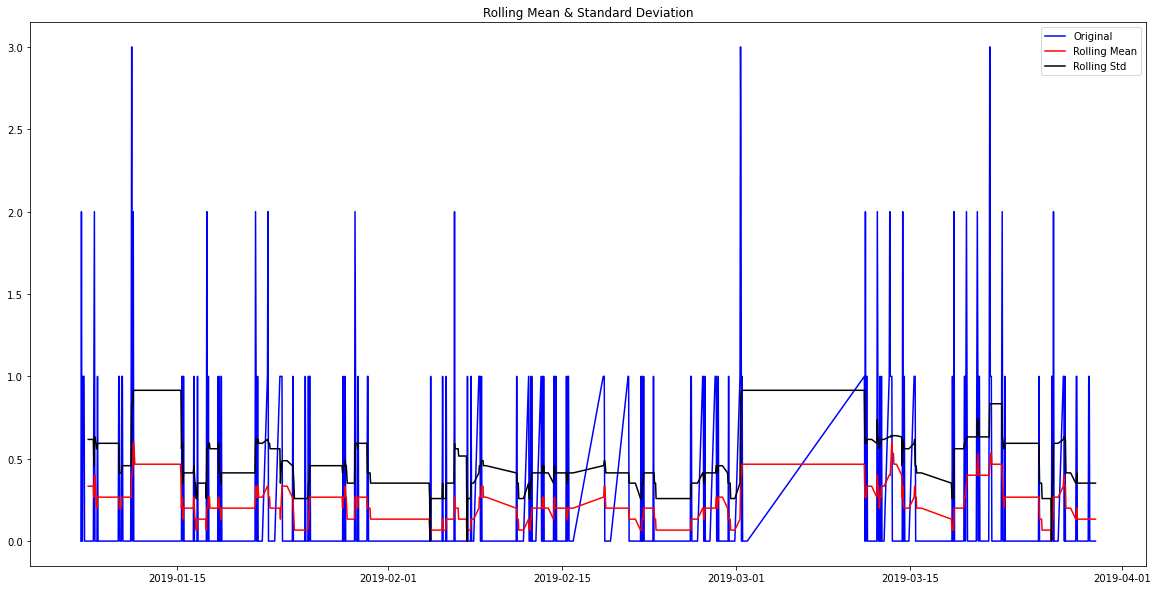

Results of Dickey-Fuller Test:
Test Statistic                  -4.739701
p-value                          0.000071
#Lags Used                      15.000000
Number of Observations Used    734.000000
Critical Value (1%)             -3.439290
Critical Value (5%)             -2.865486
Critical Value (10%)            -2.568871
dtype: float64


In [12]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=15).mean()
    rolstd = timeseries.rolling(window=15).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(train_arima)

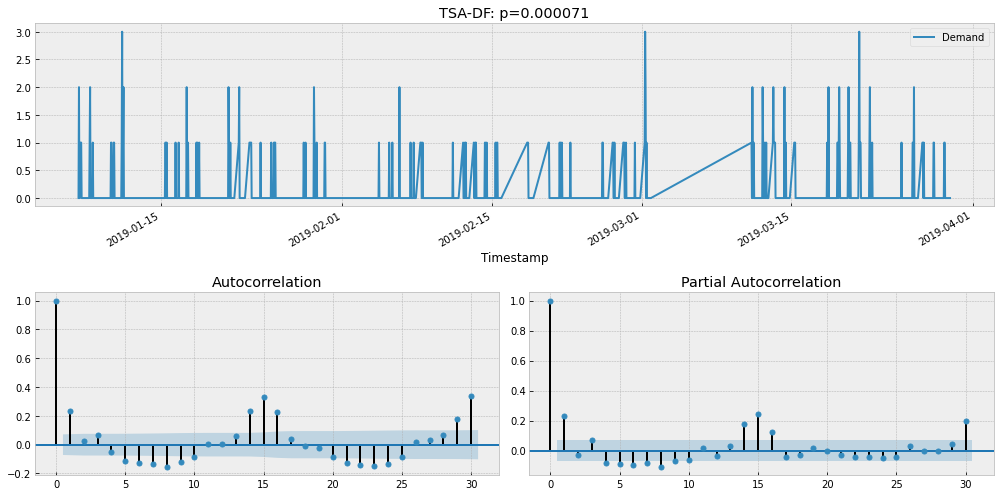

In [14]:
def ts_plot(y, lags=None, figsize=(14,7), style='bmh'):
#     if not isinstance(y, pd.Series):
#         y = pd.Series(y)
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('TSA-DF: p={0:5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
ts_plot(train_arima, lags=30)

In [ ]:
decomposition = seasonal_decompose(train_arima, period=15)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,15))
plt.subplot(411)
plt.plot(train_arima, label='Original')
plt.legend(loc='upper right')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper right')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper right')

In [ ]:
p = range(0, 3)
d = 0
q = range(0, 3)
s = 75
pdq = []
seasonal_pdq = []
for ar in p:
    for ma in q:
        param = (ar, d, ma)
        sparam = (ar, d, ma, s)
        pdq.append(param)
        seasonal_pdq.append(sparam)

# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 75) for x in list(itertools.product(p, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm_api.tsa.statespace.SARIMAX(train_arima, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{}75 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm_api.tsa.statespace.SARIMAX(train_arima,
                                order=(0, 0, 2),
                                seasonal_order=(2, 0, 2, 15),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-03-01 07:00:00'), dynamic=False)
pred_ci = pred.conf_int()

ax = train_arima['2019-01-07 07:00:00':].plot(label='observed', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand Hourly')
plt.legend()
plt.show()

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2019-03-01 07:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = train_arima['2019-01-07 07:00:00':].plot(label='observed', figsize=(14, 7))

for each in pred_dynamic.predicted_mean:
    if (each < 0):
        pred_dynamic.predicted_mean = pred_dynamic.predicted_mean.replace(each, 0)
    elif (((each*10)%10) > 3):
        pred_dynamic.predicted_mean = pred_dynamic.predicted_mean.replace(each, math.ceil(each))
    else:
        pred_dynamic.predicted_mean = pred_dynamic.predicted_mean.replace(each, math.floor(each))
        
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-04-01'), train_arima.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Demand Hourly')
plt.legend()
plt.show()

In [ ]:
pred_uc = results.get_forecast(steps=270)
pred_ci = pred_uc.conf_int()

plt.plot(pred_uc.predicted_mean)
print(pred_uc.predicted_mean, pred_ci.iloc[:, 1])
# ax = train_arima.plot(label='observed', figsize=(20, 15))
# pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
# ax.set_xlabel('Date')
# ax.set_ylabel('Demand Hourly')
# plt.legend()
# plt.show()

In [ ]:
new_list = []
y_forecasted = pred_ci.iloc[:, 1]
for each in y_forecasted:
    if (each < 0):
        each = 0
    elif (((each*10)%10) > 5):
        each = math.ceil(each)
    else:
        each = math.floor(each)
    
    new_list.append(each)

test_arima['predict'] = new_list
test_arima

In [ ]:
def cal_SMAPE(df, type):
    if type:
        smape = 100/len(df) * np.sum(2 * np.abs(df['Demand'] - df['predict_u']) / (np.abs(df['Demand']) + np.abs(df['predict_u'])))
    else:
        smape = 100/len(df) * np.sum(2 * np.abs(df['Demand'] - df['predict_n']) / (np.abs(df['Demand']) + np.abs(df['predict_n'])))
    print(df)
    return 'sMAPE', smape, 'accuracy', 100-smape

In [ ]:
rounding_boundary_sarimax = np.arange(1, 10, 1)

def grid_search_sarimax(df, pred):
    pred_n = pred
    pred_n = pred_n.predicted_mean
    pred_ci = pred.conf_int()
    pred_u = pred_ci.iloc[:, 1]
 
    round_at = []
    test_acc_n = []
    test_acc_u = []
    remark = []
    
    for boundary in rounding_boundary_sarimax:
        n_list = []
        u_list = []
        round_at.append(boundary)
        
        for each in pred_n:
            if (each < 0):
                n = 0
            elif (((each*10)%10) > boundary):
                n = math.ceil(each)
            else:
                n = math.floor(each)

            n_list.append(n)
            
        df['predict_n'] = n_list
        acc_n = cal_SMAPE(df, False)
        test_acc_n.append(acc_n)
        zero_counter_n = 0
        
        for each in n_list:
            if(each == 0):
                zero_counter_n += 1
                
#         for each in pred_u:
#             if (each < 0):
#                 u = 0
#             elif (((each*10)%10) > boundary):
#                 u = math.ceil(each)
#             else:
#                 u = math.floor(each)

#             u_list.append(u)
            
#         df['predict_u'] = u_list        
#         acc_u = cal_SMAPE(df, True)
#         test_acc_u.append(acc_u)
        zero_counter_u = 0
        
#         for each in u_list:
#             if(each == 0):
#                 zero_counter_u += 1

        if(zero_counter_n == zero_counter_u == len(df)):
            remark.append('all 0')
        elif(zero_counter_n == len(df)):
            remark.append('use upper')
        else:
            remark.append('use normal')

#     return round_at, test_acc_n, test_acc_u, remark
    return round_at, test_acc_n, remark

In [ ]:
round_at, test_acc_n, test_acc_u, remark = grid_search_sarimax(test_arima, pred_uc)
grid = {'Round at': round_at, 'Test': test_acc_n, 'Test(upper)': test_acc_u, 'Remark': remark}    
df_grid = pd.DataFrame(grid)
df_grid

In [ ]:
round_at, test_acc_n, remark = grid_search_sarimax(test_arima, pred_uc)
grid = {'Round at': round_at, 'Test': test_acc_n, 'Remark': remark}    
df_grid = pd.DataFrame(grid)
df_grid